# Estimating grid cell fire probabailities with Random Forests

Authors: Jatan Buch (v1, 220207)

## 1 - Packages

In [1]:
import numpy as np
import pandas as pd
#from time import clock
from datetime import date, datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm
from copy import deepcopy

#Import and write files
import csv
import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *
from ml_utils import *

#Helper functions
from math import factorial
from scipy import stats
from scipy.special import gamma
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
from tensorflow.python import ops
from tensorflow.python import debug as tf_debug

#Plot modules
import matplotlib.pyplot as plt
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

#Stats modules
from scipy import stats
from scipy.stats import norm, pareto, genpareto
import statsmodels.api as sm
from scipy import stats, interpolate
from scipy.optimize import minimize

# Data processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib

#modules for Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
import shap

#modules for Neural Network
import tensorflow as tf
import tensorflow_probability as tfp
tfd= tfp.distributions
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
#from tensorflow.keras import layers
#from tensorflow.python.ops.parallel_for.gradients import jacobian

In [2]:
data_dir= "../data/"
clim_df= pd.read_hdf('../data/clim_fire_freq_12km_data.h5')
clim_df.loc[clim_df[clim_df.fire_freq > 1].index, 'fire_freq']= np.ones(len(clim_df[clim_df.fire_freq > 1].index), dtype= np.int64)

In [15]:
gpd_train_acc, gpd_val_acc, gpd_train_loss, gpd_val_loss, gpd_acc_iter, gpd_val_acc_iter, gpd_loss_iter, gpd_val_loss_iter= \
     validation_cycle(n_layers= 2, n_neurons= 16, n_components= 2, epochs= 300, lr= 1e-4, X_dat= X_sizes_train, y_dat= y_sizes_train, X_val_dat= X_sizes_val, \
                      y_val_dat= y_sizes_val, fire_tag= 'size', func_flag= 'gpd')

  0%|          | 0/5 [00:00<?, ?it/s]

Validation iteration 1 for fire size MDN with gpd loss function


 20%|██        | 1/5 [01:02<04:11, 62.83s/it]

Validation iteration 2 for fire size MDN with gpd loss function


 40%|████      | 2/5 [02:00<02:59, 59.75s/it]

Validation iteration 3 for fire size MDN with gpd loss function


 60%|██████    | 3/5 [03:12<02:10, 65.47s/it]

Validation iteration 4 for fire size MDN with gpd loss function


 80%|████████  | 4/5 [04:24<01:08, 68.02s/it]

Validation iteration 5 for fire size MDN with gpd loss function


100%|██████████| 5/5 [05:25<00:00, 65.04s/it]


In [16]:
print('Training Loss: ', np.nanmean(gpd_loss_iter))
print('Validation Loss: ', np.nanmean(gpd_val_loss_iter))
print('Training Accuracy: ', np.nanmean(gpd_acc_iter))
print('Validation Accuracy: ', np.nanmean(gpd_val_acc_iter))

Training Loss:  3.3353403409322104
Validation Loss:  3.36277437210083
Training Accuracy:  89.56227366129558
Validation Accuracy:  89.48051452636719


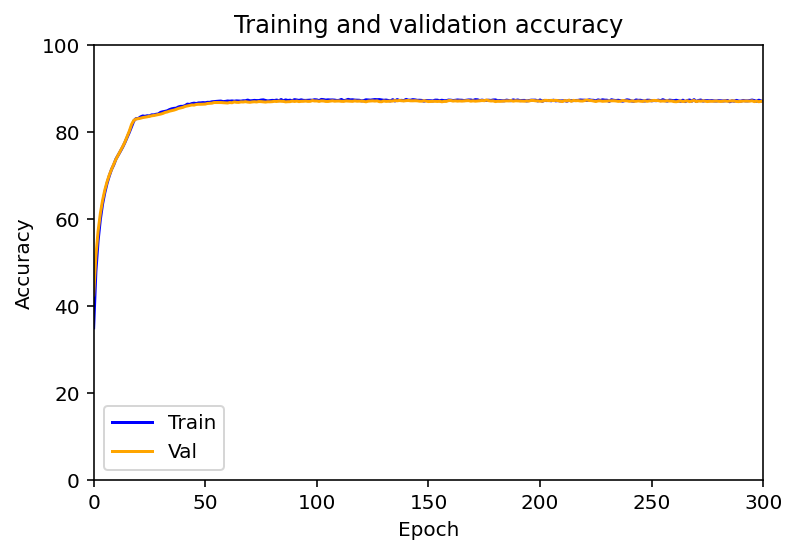

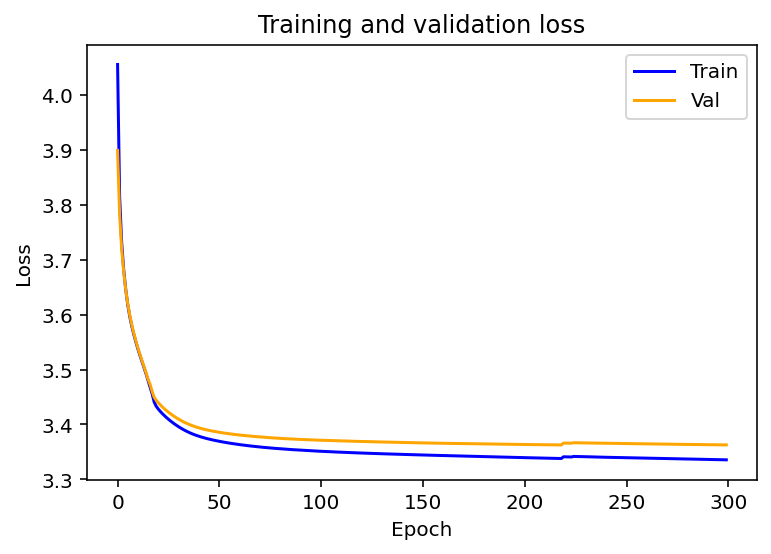

In [25]:
plt.title('Training and validation accuracy')

plt.plot(range(len(gpd_train_acc[0])), np.nanmean(gpd_train_acc, axis= 0), color='blue', label='Train')
plt.plot(range(len(gpd_val_acc[0])), np.nanmean(gpd_val_acc, axis= 0), color='orange', label='Val')
plt.ylim(0, 100);
plt.xlim(0, 300);
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


_ = plt.figure()
plt.title('Training and validation loss')
plt.plot(range(len(gpd_train_loss[0])), np.nanmean(gpd_train_loss, axis= 0), color='blue', label='Train')
plt.plot(range(len(gpd_val_loss[0])), np.nanmean(gpd_val_loss, axis= 0), color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
lognorm_train_acc, lognorm_val_acc, lognorm_train_loss, lognorm_val_loss, lognorm_acc_iter, lognorm_val_acc_iter, lognorm_loss_iter, lognorm_val_loss_iter= \
     validation_cycle(n_layers= 2, n_neurons= 8, n_components= 3, X_dat= X_sizes_train, y_dat= y_sizes_train, X_val_dat= X_sizes_val, \
                      y_val_dat= y_sizes_val, fire_tag= 'size', func_flag= 'lognorm')

  0%|          | 0/5 [00:00<?, ?it/s]

Validation iteration 1 for fire size MDN with lognorm loss function


 20%|██        | 1/5 [00:26<01:45, 26.30s/it]

Validation iteration 2 for fire size MDN with lognorm loss function


 40%|████      | 2/5 [01:10<01:50, 36.98s/it]

Validation iteration 3 for fire size MDN with lognorm loss function


 60%|██████    | 3/5 [01:34<01:01, 30.98s/it]

Validation iteration 4 for fire size MDN with lognorm loss function


 80%|████████  | 4/5 [02:00<00:29, 29.17s/it]

Validation iteration 5 for fire size MDN with lognorm loss function


100%|██████████| 5/5 [02:28<00:00, 29.67s/it]


In [16]:
print('Training Loss: ', np.nanmean(lognorm_loss_iter))
print('Validation Loss: ', np.nanmean(lognorm_val_loss_iter))
print('Training Accuracy: ', np.nanmean(lognorm_acc_iter))
print('Validation Accuracy: ', np.nanmean(lognorm_val_acc_iter))

Training Loss:  3.183659219741821
Validation Loss:  3.162890911102295
Training Accuracy:  87.57426605224609
Validation Accuracy:  86.00187072753906


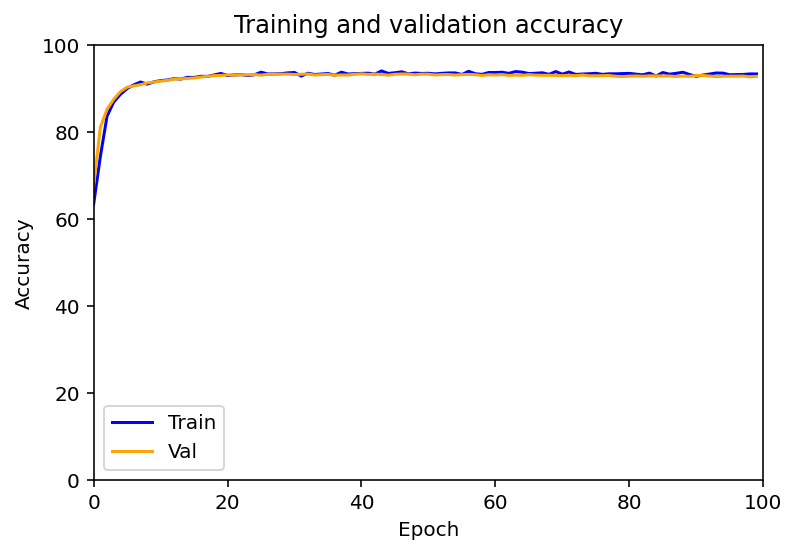

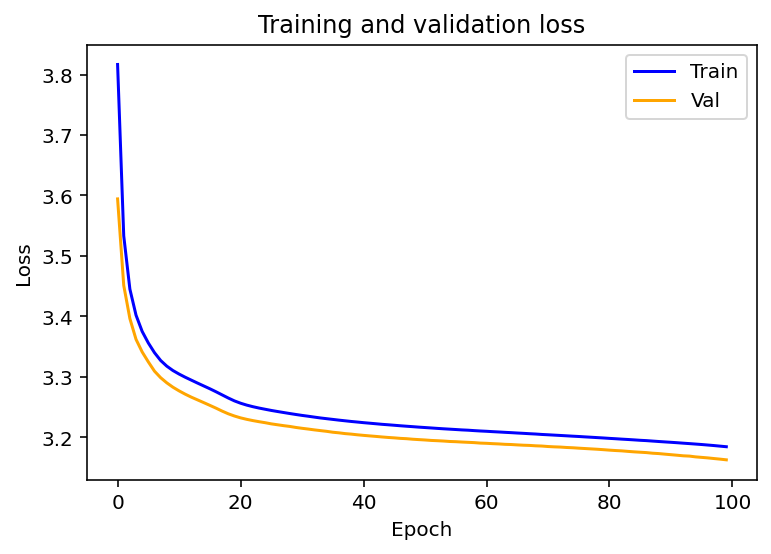

In [15]:
plt.title('Training and validation accuracy')

plt.plot(range(len(lognorm_train_acc[0])), np.mean(lognorm_train_acc, axis= 0), color='blue', label='Train')
plt.plot(range(len(lognorm_val_acc[0])), np.mean(lognorm_val_acc, axis= 0), color='orange', label='Val')
plt.ylim(0, 100);
plt.xlim(0, 100);
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


_ = plt.figure()
plt.title('Training and validation loss')
plt.plot(range(len(lognorm_train_loss[0])), np.mean(lognorm_train_loss, axis= 0), color='blue', label='Train')
plt.plot(range(len(lognorm_val_loss[0])), np.mean(lognorm_val_loss, axis= 0), color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Fire occurrence prediction with Random Forest

We use a random forest classifier to predict if a fire occurs or not. This is a binary classification problem: the model outputs 1 if a fire occurs and 0 otherwise.

In [3]:
clim_df.head() #clim_df.shape ~1e7

,Tmax,VPD,Prec,Antprec_lag1,Forest,Solar,Wind,Elev,Grassland,RH,...,VPD_max7,Tmax_max3,Tmax_max7,Tmin_max3,Tmin_max7,Slope,Southness,AvgVPD_4mo,AvgVPD_2mo,fire_freq
0,7.51,2.41,181.070007,86.695839,0.853861,43.270000,8.42,46.709999,0.009268,73.000000,...,3.62,9.49,8.91,7.30,6.88,0.92,-0.17,3.5025,2.740,0
1,7.41,2.38,202.220001,95.421669,0.467644,43.160000,4.71,47.369999,0.014522,73.180000,...,3.71,11.46,9.62,6.19,5.22,1.23,-0.06,3.3375,2.600,0
2,7.28,2.33,207.389999,95.521667,0.756240,45.689999,3.76,74.360001,0.000565,73.370003,...,3.72,12.62,9.88,6.47,5.06,0.54,0.04,3.1775,2.455,0
3,7.74,2.61,159.919998,77.969994,0.429114,43.009998,7.95,24.000000,0.012174,71.089996,...,3.59,9.41,8.88,7.39,6.84,1.01,-0.16,3.7150,2.895,0
4,7.62,2.70,178.570007,84.817497,0.501928,41.669998,4.69,34.830002,0.012440,69.800003,...,3.65,10.39,9.36,6.80,5.62,0.58,-0.15,3.6775,2.895,0


In [18]:
#run_id= '22_02_07'
#param_df= rf_hyperparam_tuning(clim_df, n_iters= 5, run_id= run_id)
#param_df.to_hdf('../sav_files/rf_runs_%s'%run_id + '/rf_params_%s.h5'%run_id, key= 'df', mode= 'w')

In [53]:
run_id= '22_02_07'
param_df= pd.read_hdf('../sav_files/rf_runs_%s'%run_id + '/rf_params_%s.h5'%run_id)
param_df['tot_metric']= param_df['Test Accuracy']*param_df['Test Recall']

In [54]:
param_df.sort_values(by= ['tot_metric'], ascending= False).fillna(value= 0.0).groupby('Threshold').get_group(0.5).groupby('Trees').get_group(250)

,Iteration,Trees,Rebalance frac,Threshold,Train Accuracy,Train Recall,Test Accuracy,Test Recall,tot_metric
136,2,250,2.333333,0.5,0.847000,0.741729,0.813493,0.820091,0.667138
46,1,250,2.333333,0.5,0.854900,0.747784,0.815683,0.817679,0.666967
406,5,250,2.333333,0.5,0.850900,0.745693,0.816855,0.814983,0.665723
316,4,250,2.333333,0.5,0.845700,0.740541,0.820515,0.811010,0.665446
226,3,250,2.333333,0.5,0.852000,0.747268,0.819982,0.808173,0.662687
409,5,250,1.500000,0.5,0.835867,0.797099,0.707111,0.913593,0.646012
229,3,250,1.500000,0.5,0.842533,0.798705,0.708732,0.911039,0.645682
49,1,250,1.500000,0.5,0.833600,0.791861,0.704459,0.912599,0.642889
319,4,250,1.500000,0.5,0.838667,0.800000,0.707501,0.908059,0.642452
139,2,250,1.500000,0.5,0.832533,0.793828,0.706526,0.907633,0.641267


In [ ]:
#%time rf, forest, train_metrics, test_metrics= rf_fire_grid_run(clim_grid_df= clim_df, rb_frac= 7/3, n_features= 36, threshold= None, criterion= 'entropy')

### Variable Importance

In [15]:
pimp_flag= False
feature_list= list(clim_df.iloc[:, 0:20].drop(columns= ['Solar', 'Ant_Tmax', 'RH', 'Ant_RH']).columns)
if not pimp_flag:
    importances= list(forest.feature_importances_)
    feature_importances= [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
else:
    importances= permutation_importance(forest, X, y, n_repeats=10, random_state=42, n_jobs= -1)
    feature_importances= [(feature, abs(importance)) for feature, importance in zip(feature_list, importances['importances_mean'])]
feature_importances = sorted(feature_importances, key= lambda x: x[1], reverse= True)
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))

Variable: FM1000               Importance: 0.0988
Variable: VPD                  Importance: 0.0987
Variable: Tmax                 Importance: 0.0795
Variable: Solar                Importance: 0.0768
Variable: Antprec_lag1         Importance: 0.0694
Variable: Tmin                 Importance: 0.0683
Variable: Prec                 Importance: 0.0501
Variable: Ant_Tmax             Importance: 0.0495
Variable: Forest               Importance: 0.049
Variable: Grassland            Importance: 0.0487
Variable: AvgVPD_3mo           Importance: 0.047
Variable: CAPE                 Importance: 0.0449
Variable: Avgprec_3mo          Importance: 0.0427
Variable: Wind                 Importance: 0.0406
Variable: Elev                 Importance: 0.0401
Variable: FFWI_max3            Importance: 0.034
Variable: FFWI_max7            Importance: 0.0335
Variable: Urban                Importance: 0.0285


Text(0.5, 1.0, 'Variable Importance')

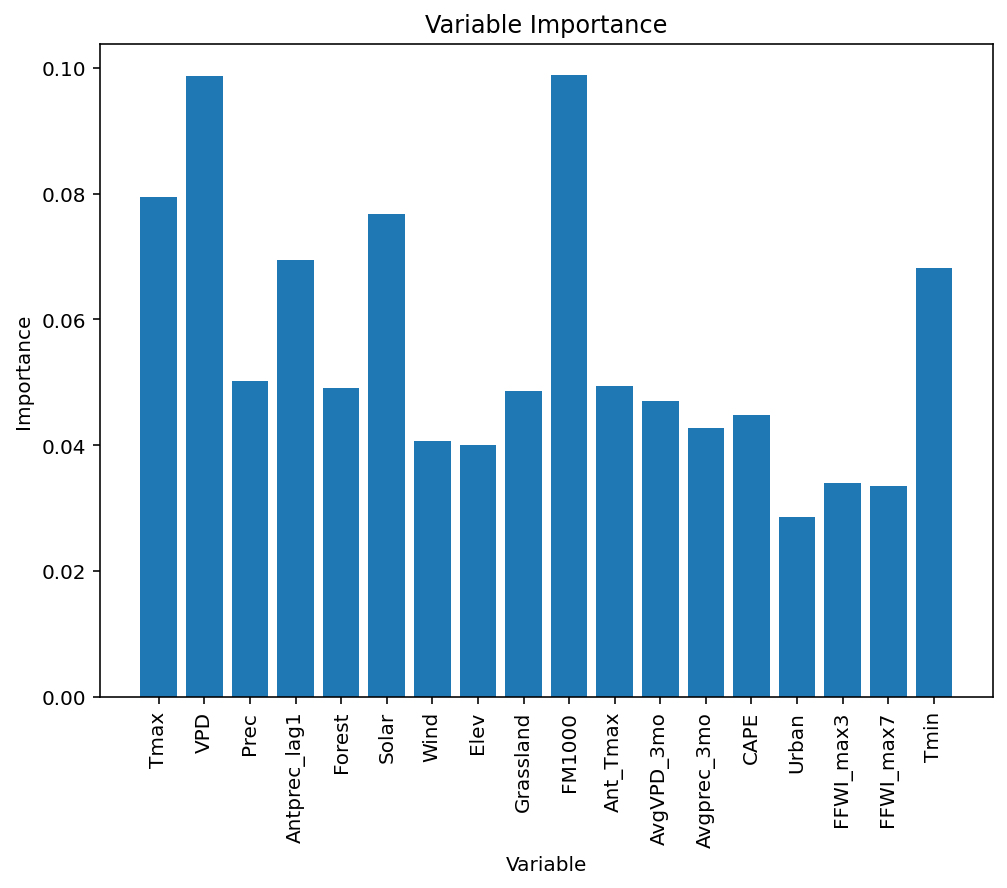

In [16]:
plt.rcParams["figure.figsize"] = (8, 6)
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importance')

### Sanity check

In [92]:
rb_frac= 75/25 #fraction of no fires to fires

df1= clim_df[clim_df['fire_freq']==1]
n1= len(df1)

n2= rb_frac*n1
df2= clim_df[clim_df['fire_freq']==0]
df2= df2.sample(n= int(n2))

df_r= pd.concat([df1, df2], sort= False).sample(frac= 1).reset_index(drop=True) #shuffling the rows

In [93]:
y_r = np.array(df_r.fire_freq)
X_r = df_r.iloc[:, 0:36].drop(columns= ['Solar', 'Ant_Tmax','RH', 'Ant_RH']) #'solar', 'prec', 'deltaT', 'tmin','wind','forest','urban'

minmax_scaler = MinMaxScaler()
X_r = minmax_scaler.fit_transform(X_r)
X_r = np.array(X_r, dtype=np.float32)

X_train, X_val, y_train, y_val = train_test_split(X_r, y_r, test_size=0.3, random_state= 99)

#### Training

In [94]:
# Instantiate model with n_estimators decision trees
rf= RandomForestClassifier(n_estimators= 100, random_state= 87)

In [95]:
# Train the model on training data
%time forest= rf.fit(X_train, y_train)

CPU times: user 15.7 s, sys: 89.9 ms, total: 15.8 s
Wall time: 15.9 s


#### Testing on validation set

In [96]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_val)
# Calculate the absolute errors
errors = abs(predictions - y_val)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 6), 'degrees.')

Mean Absolute Error: 0.150406 degrees.


In [97]:
pscore = metrics.accuracy_score(y_val, predictions)
print("accuracy: ", pscore)
score = metrics.f1_score(y_val, predictions)
print("f1 score: ", score)
recall = metrics.recall_score(y_val, predictions)
print("recall: ", recall)

accuracy:  0.849594290742008
f1 score:  0.6870741381063764
recall:  0.6535113174695298


In [68]:
cf = confusion_matrix(y_val, predictions)
cf

array([[14120,  1260],
       [ 1720,  3358]])

In [75]:
threshold= 0.4
predicted_thresh= rf.predict_proba(X_val)
predicted_thresh= (predicted_thresh[:, 1] >= threshold).astype('int')

In [76]:
pscore = metrics.accuracy_score(y_val, predicted_thresh)
print("accuracy: ", pscore)
score = metrics.f1_score(y_val, predicted_thresh)
print("f1 score: ", score)
recall = metrics.recall_score(y_val, predicted_thresh)
print("recall: ", recall)

accuracy:  0.8487144393391338
f1 score:  0.7172224760164457
recall:  0.7729421031902324


In [77]:
cf = confusion_matrix(y_val, predicted_thresh)
cf

array([[13438,  1942],
       [ 1153,  3925]])

#### Testing on real dataset

In [78]:
y= np.array(clim_df.fire_freq)
X= clim_df.iloc[:, 0:20].drop(columns= ['RH', 'Ant_RH'])
minmax_scaler= MinMaxScaler()
X= minmax_scaler.fit_transform(X)
X= np.array(X, dtype=np.float32)

In [79]:
# Use the forest's predict method on the test data
%time predictions= rf.predict(X)
# Calculate the absolute errors
errors = abs(predictions - y)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 6), 'degrees.')

CPU times: user 1min 31s, sys: 6.88 s, total: 1min 38s
Wall time: 1min 47s
Mean Absolute Error: 0.070219 degrees.


In [80]:
pscore = metrics.accuracy_score(y, predictions)
print("accuracy: ", pscore)
score = metrics.f1_score(y, predictions)
print("f1 score: ", score)
recall = metrics.recall_score(y, predictions)
print("recall: ", recall)

accuracy:  0.9297813036020584
f1 score:  0.028808199380385296
recall:  0.6308071328015017


In [81]:
cf = confusion_matrix(y, predictions)
cf

array([[9590257,  718791],
       [   6294,   10754]])

In [89]:
threshold= 0.35
%time predicted_thresh= rf.predict_proba(X)
predicted_thresh= (predicted_thresh[:, 1] >= threshold).astype('int')

In [90]:
pscore = metrics.accuracy_score(y, predicted_thresh)
print("accuracy: ", pscore)
score = metrics.f1_score(y, predicted_thresh)
print("f1 score: ", score)
recall = metrics.recall_score(y, predicted_thresh)
print("recall: ", recall)

accuracy:  0.8544066411933416
f1 score:  0.01845940908215462
recall:  0.8292468324730173


In [91]:
cf = confusion_matrix(y, predicted_thresh)
cf

array([[8808548, 1500500],
       [   2911,   14137]])

### Testing

In [6]:
tot_months= 60
n_regions= 18

month_arr= np.linspace(0, tot_months - 1, tot_months, dtype= int)
year_arr= np.asarray([2015, 2016, 2017, 2018, 2019, 2020]) 

reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW", 6: "Columbia Plateau", 7:"Northern Rockies", \
          8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains", 15: "High Plains", 16: "CO Plateau", 17: "SW Tablelands", 18: "CH Desert"}